# Forecasting stratigies

This notebook describes some strategies of foreacsting.

Notebook navigation:
- [Intro](#20-intro)
- [Pipeline](#21-pipeline-class-pipeline)
- [AutoregressivePipeline](#22-autoregressive-pipeline-class-autoregressivepipeline)
- [DirectEnsemble](#23-ensembles-class-directensemble)
- [assemble_pipelines + DirectEnsemble](#24-assemble-pipelines-with-ensembles-method-assemblepipelines-class-directensemble)

In [1]:
import warnings

warnings.filterwarnings("ignore")

## 1. Load Dataset

Let's load and plot the dataset:

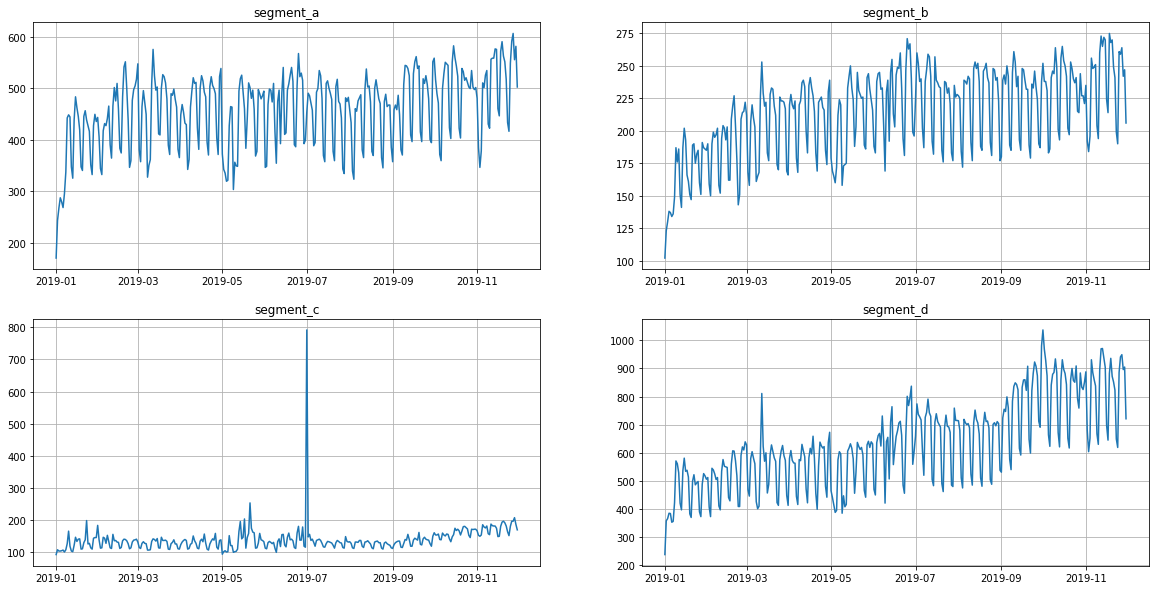

In [2]:
import pandas as pd
from etna.datasets import TSDataset

df = pd.read_csv("data/example_dataset.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = TSDataset.to_dataset(df)
ts = TSDataset(df, freq="D")

ts.plot()

In [3]:
HORIZON = 14

## 2. Strategies

### 2.0 Intro

There are several possible forecasting strategies available in ETNA, and in this section, we will look at them in details.

### 2.1 Pipeline (class Pipeline)

Pipeline is a base strategy of forecasting. It accepts as input model, list of transforms and horizon. In fit method pipeline transforms data with input transforms and after that it gives data to model to fit it. In `predict` method model gets test matrics of features with shape $horizon \times features$ and get `horizon` forecastings.

This strategy can be effective when we forecast in small horizons. If we use lags of series as features, in large horizons we use large lags of series, which can be not actual for our forecastings.

#### Let's look at expample of usage:

As features we will use linear trend transform(because we are working with tree-based models) and lags of input series. `Note`: we have to use lags that are more than `HORIZON`. It's necessary because last model should not contain `Nans` in features.

In [4]:
from etna.pipeline import Pipeline
from etna.models import CatBoostModelPerSegment
from etna.transforms import LagTransform
from etna.transforms import LinearTrendTransform
from etna.metrics import SMAPE, MAE, MAPE

model = CatBoostModelPerSegment()
transforms = [
    LinearTrendTransform(in_column="target"),
    LagTransform(in_column="target", lags=list(range(HORIZON + 1, 40)), out_column="target_lag"),
]

pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)
metrics_df_original_catboost, forecast_df, fold_info_df = pipeline.backtest(ts=ts, metrics=[SMAPE(), MAE(), MAPE()])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   32.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   56.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.0min finished


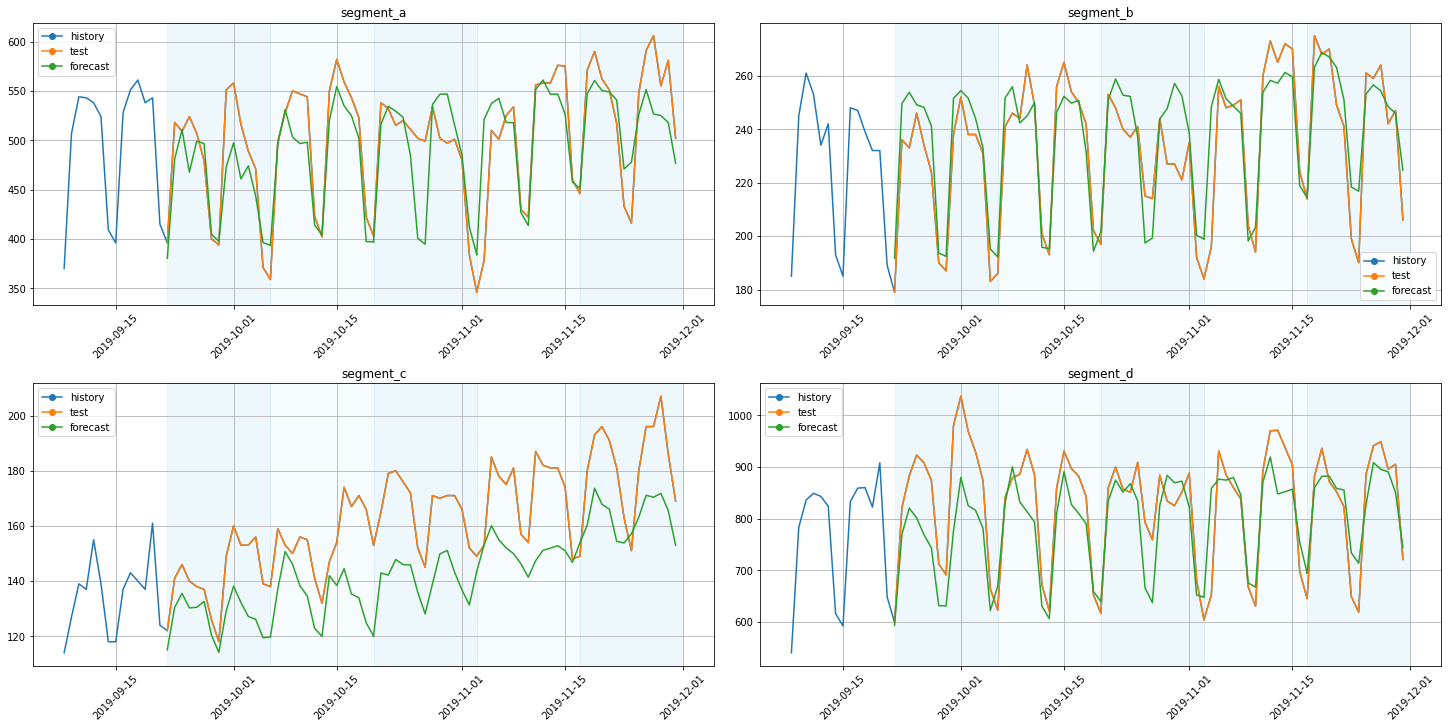

In [5]:
from etna.analysis import plot_backtest

plot_backtest(forecast_df, ts, history_len=HORIZON)

In [6]:
pipeline_metric = metrics_df_original_catboost.mean(axis=0)

### 2.2 Autoregressive pipeline (class AutoRegressivePipeline)

AutoRegressive pipeline is pipeline, which iteratively forecasts `step` values and after that uses forecasted values as features. `step` is parameter of AutoregressivePipeline and it should be less than `HORIZON`.

This method allows to use lags, that are lower than `HORIZON`. However, this approach could be imprecise on forecastings with large horizons. The thing is that we accumulate errors of forecastins for further horizons. 

#### Let's look an example of usage: 

We will use the same transforms and model as we used above, but with one exception - we can use lags, that are low or equals than `HORIZON`

In [7]:
from etna.pipeline import AutoRegressivePipeline

model = CatBoostModelPerSegment()
transforms = [
    LinearTrendTransform(in_column="target"),
    LagTransform(in_column="target", lags=[i for i in range(1, 20)], out_column="target_lag"),
]

pipeline = AutoRegressivePipeline(model=model, transforms=transforms, horizon=HORIZON)
metrics_df, forecast_df, fold_info_df = pipeline.backtest(ts=ts, metrics=[SMAPE(), MAE(), MAPE()])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   57.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.1min finished


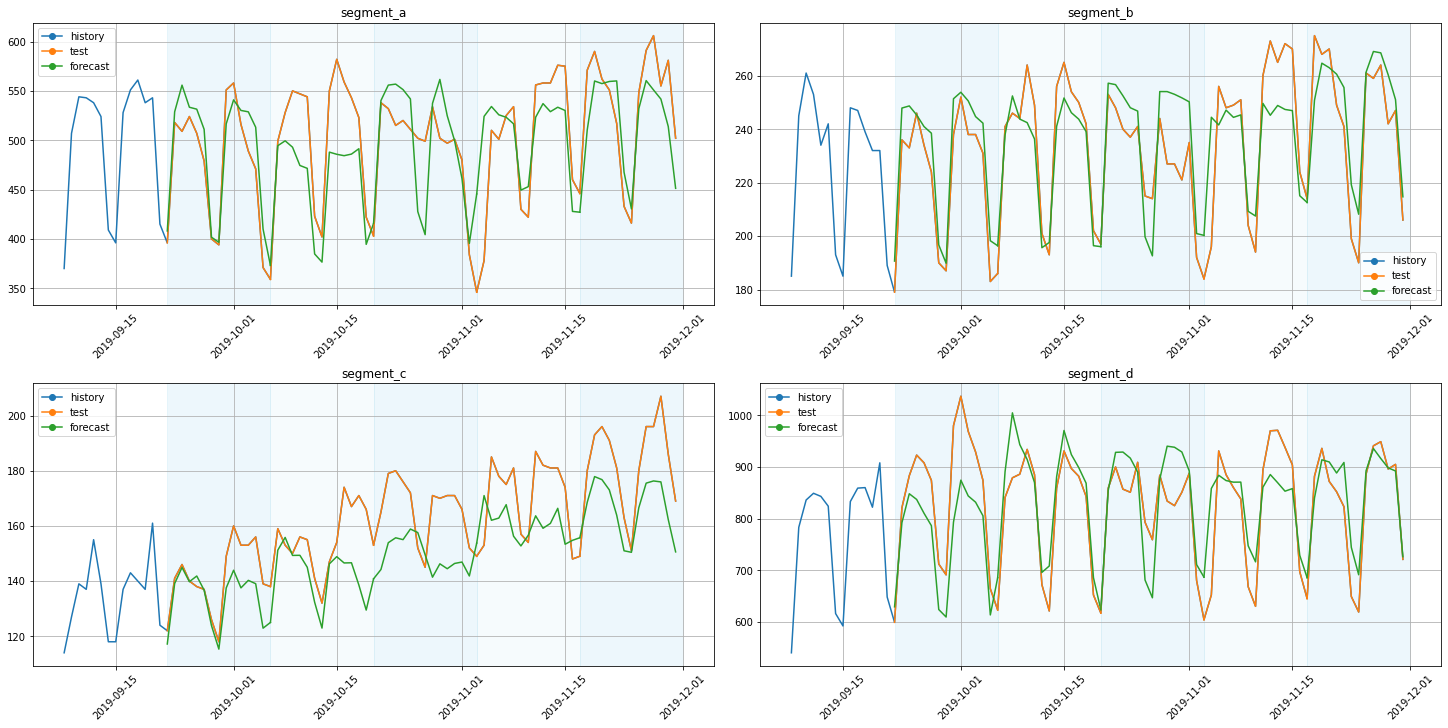

In [8]:
plot_backtest(forecast_df, ts, history_len=HORIZON)

In [9]:
autoregressive_pipeline_metrics = metrics_df.mean(axis=0)

### 2.3 Ensembles (class DirectEnsemble)

DirectEnsemble is a pipeline that forecasts future values merging the forecasts of the base pipelines. For each future value we select base pipeline with shortest horizon that spans the timestamp of interesitng value. Let's see an example of choosing base-pipeline for forecastings:

![title](./assets/forecasting_strategies/ensemle.png)



This strategy can be useful when we have different pipelines, that are effective on different horizons.

#### Example
 Let we know that pipeline with `CatBoost` model is effective than `NaiveModel` on small horizons, and on the contrary, `NaiveModel` is better on large `horizons`. It is logical to conclude, that it's better to forecast first points with `NaiveModel` and others with `CatBoost` and achieve better performance, than both models individually. However, this approach requires more time, because we calculate values, that are not used in final forecastings. In our example we need to forecast first few points for `CatBoost` and these forecasted values are not used in final forecastings.

#### Let's build DirectEnsemble with etna:

First, let's build our pipelines:

In [10]:
train_ts, test_ts = ts.train_test_split(test_size=14)

In [11]:
from etna.models import NaiveModel

horizons = [10, 14]

model_1 = CatBoostModelPerSegment()
transforms_1 = [
    LinearTrendTransform(in_column="target"),
    LagTransform(in_column="target", lags=[i for i in range(10, 20)], out_column="target_lag"),
]
pipeline_1 = Pipeline(model=model_1, transforms=transforms_1, horizon=horizons[0])


model_2 = NaiveModel(lag=3)
transforms_2 = []

pipeline_2 = Pipeline(model=model_2, transforms=transforms_2, horizon=horizons[1])

Secondly, we will create ensemble and forecasts:

In [13]:
from etna.ensembles import DirectEnsemble

ensemble = DirectEnsemble(pipelines=[pipeline_1, pipeline_2])

metrics_df_ensemble, forecast_df, fold_info_df = ensemble.backtest(ts=ts, metrics=[SMAPE(), MAE(), MAPE()])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    

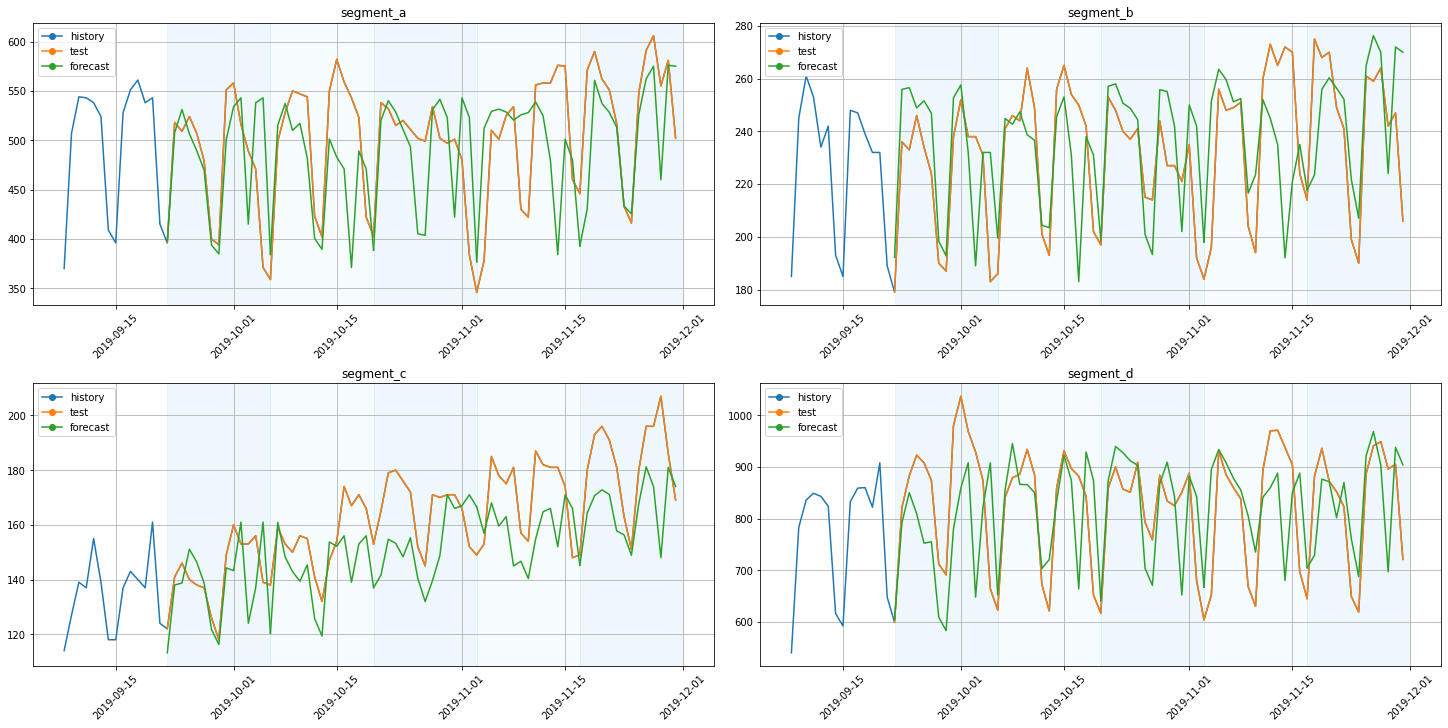

In [14]:
plot_backtest(forecast_df, ts, history_len=HORIZON)

In [15]:
ensemble_metrics = metrics_df_ensemble.mean(axis=0)

## 2.4 assemble pipelines with ensembles (method assemble_pipelines, class DirectEnsemble)

DirectEnsemble has been described above, so let's take a look at assemble pipelines. `assemble_pipelines` is a function, that generates `Pipelines` from a set of input models, transforms and horizons according to some rules:

1. Input models can be specified as one model or as a sequence of models. In first case all generated pipelines will have input model and in the second case `i`-th pipeline will hold `i`-th model. 
2. Similar to paragraph 1, but for horizons.
3. Transforms can be specified as a sequence of transform or as a sequence of sequence of transforms. Let's look at some examples to understand better transformations with transforms:

Let's consider that `A`, `B`, `C`, `D`, `E` are different transforms.

### Example 1

If input transform sequence is `[A, B, C]`, function will transformate in `[A, B, C]` for each pipeline

### Example 2

If input transform sequence is `[A, [B, C], D, E]`, function will put `[A, B, D, E]` for the first generated pipeline and `[A, C, D, E]` for the second.

### Example 3

If input transform sequence is `[A, [B, C], [D, E]]`, function will put `[A, B, D]` for the first generated pipeline and `[A, C, E]` for the second.

### Example 4

If input transform sequence is `[A, [B, None]]`, function will put `[A, B]` for the first generated pipeline and `[A]` for the second.


This function can be comfortable for generating pipelines for DirectEnsemble, let's override our previous pipelines:


In [16]:
from etna.pipeline import assemble_pipelines

models = [CatBoostModelPerSegment(), NaiveModel(lag=3)]
transforms = [
    [LinearTrendTransform(in_column="target"), None],
    [LagTransform(in_column="target", lags=[i for i in range(10, 20)], out_column="target_lag"), None],
]
horizons = [10, 14]

pipelines = assemble_pipelines(models=models, transforms=transforms, horizons=horizons)
pipelines

[Pipeline(model = CatBoostModelPerSegment(iterations = None, depth = None, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LinearTrendTransform(in_column = 'target', poly_degree = 1, ), LagTransform(in_column = 'target', lags = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19], out_column = 'target_lag', )], horizon = 10, ),
 Pipeline(model = NaiveModel(lag = 3, ), transforms = [], horizon = 14, )]

Now pipelines generation look a bit simpler and we can put our pipelines into DirectEnsemble:

In [17]:
ensemble = DirectEnsemble(pipelines=pipelines)

metrics_df, forecast_df, fold_info_df = ensemble.backtest(ts=ts, metrics=[SMAPE()])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   1

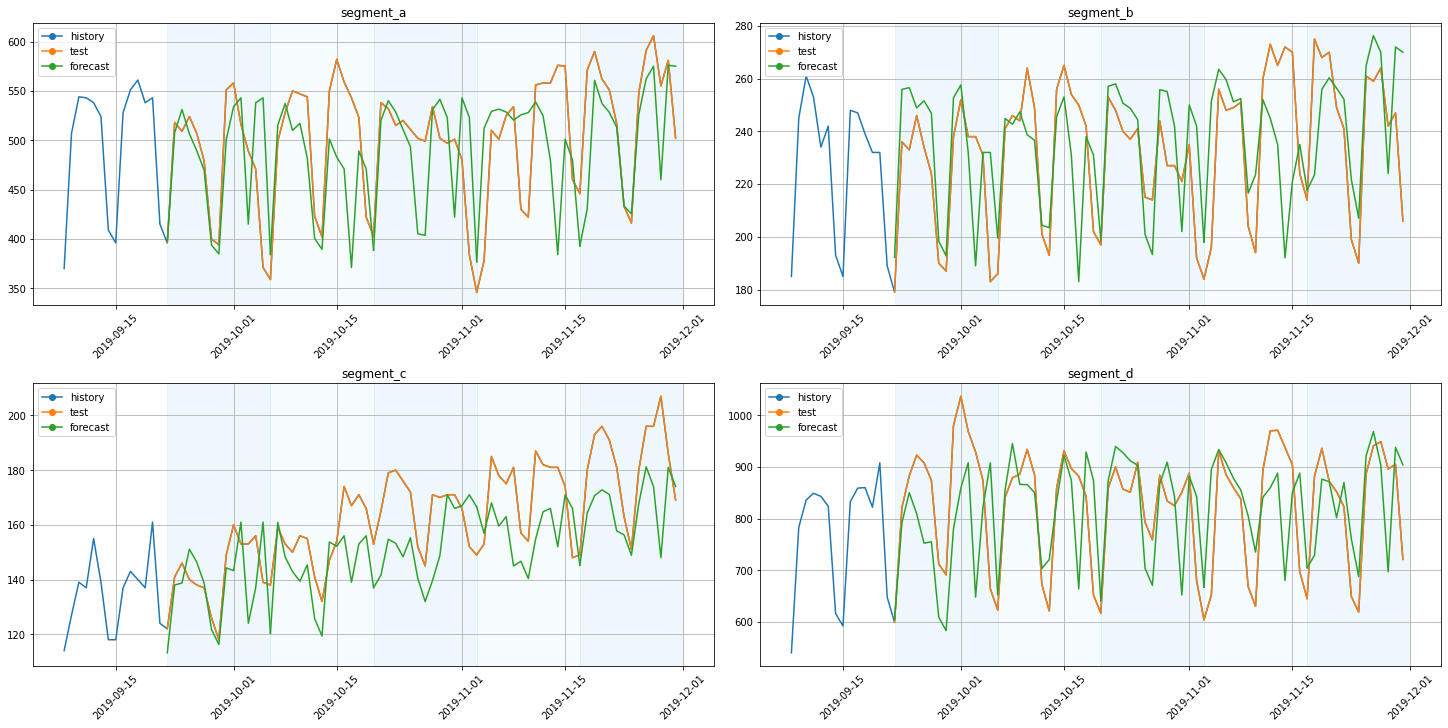

In [18]:
plot_backtest(forecast_df, ts, history_len=HORIZON)

## Summary

Let's compare all metrics:

In [19]:
df_res = pd.DataFrame(
    data=[ensemble_metrics, pipeline_metric, autoregressive_pipeline_metrics],
    index=["direct_ensemble", "pipeline", "autoregressive_pipeline"],
).drop("fold_number", axis=1)
df_res

,SMAPE,MAE,MAPE
direct_ensemble,9.345614,40.964906,9.229230
pipeline,7.588562,29.441407,7.329067
autoregressive_pipeline,6.983119,29.496753,6.896113
